# Исследование маркетинговой активности для приложения Procrastinate Pro+

## Задачи исследования
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.
<br> Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
<br> -лог сервера с данными об их посещениях,
<br> -выгрузка их покупок за этот период,
<br> -рекламные расходы.
<br> Необходимо изучить:
<br> -откуда приходят пользователи и какими устройствами они пользуются,
<br> -сколько стоит привлечение пользователей из различных рекламных каналов;
<br> -сколько денег приносит каждый клиент,
<br> -когда расходы на привлечение клиента окупаются,
<br> -какие факторы мешают привлечению клиентов.

## Предобработка данных

### Загрузка данных и подготовка к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим данные и выполним предобработку. Есть ли в данных пропуски и дубликаты? Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. 

In [1]:
#импортируем все необходимые библиотеки:

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


In [2]:
try:
    visits, orders, costs = (
    pd.read_csv( '/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv( '/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
    )
except:
    print("Произошла ошибка")

In [3]:
visits.info()
orders.info()
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Пропусков данных нет. Названия столбцов стоит привести к змеиному регистру. Для нескольких столбцов требуется замена формата на дату. 

In [4]:
#приводим названия колонок к змеиному регистру
visits = visits.rename(columns={"User Id": "user_id", "Region": "region", "Device": "device", "Channel": "channel","Session Start": "session_start","Session End": "session_end"})
orders = orders.rename(columns={"User Id": "user_id", "Event Dt": "event_dt", "Revenue": "revenue"})
costs = costs.rename(columns={"Channel": "channel"})
print(visits.head(),"\n","\n",    
      orders.head(),"\n","\n",
      costs.head()
      )

        user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40   
 
         user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99 
 
            dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  

In [5]:
#прорверим данные на наличие явных дубликатов:
print(visits.duplicated().sum(),
orders.duplicated().sum(),
costs.duplicated().sum())

0 0 0


In [6]:
#прорверим данные на наличие неявных дубликатов:
print(visits['region'].sort_values().unique())
print(visits['device'].sort_values().unique())
print(visits['channel'].sort_values().unique())
costs['channel'].sort_values().unique()

pd.set_option('display.max_rows', None)

['France' 'Germany' 'UK' 'United States']
['Android' 'Mac' 'PC' 'iPhone']
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Явных и неявных дубликатов нет

In [7]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date #данные о времени нам здесь не понадобятся

print(visits.info(),
      orders.info(),
      costs.info()
     )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Данные о времени и датах приведены к соответствующему формату. 
<br> Критичных ошибок в данных нет, форматы исправлены, можно приступать написанию функций   

## Функции для исследования

### Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [16]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [17]:
min_dt = pd.to_datetime(profiles['first_ts']).dt.date.min()
max_dt = pd.to_datetime(profiles['first_ts']).dt.date.max()
print('минимальная дата привлечения:', min_dt)
print('максимальная дата привлечения:', max_dt)


минимальная дата привлечения: 2019-05-01
максимальная дата привлечения: 2019-10-27


In [18]:
#число уникальных пользователей по странам:
region_users = (
        profiles.groupby(['region'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
region_users

,region,unique_users
0,France,17450
1,Germany,14981
2,UK,17575
3,United States,100002


In [19]:
#число уникальных покупателей по странам:
region_payers = (
         profiles.query('payer==True')   
        .groupby(['region'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers'})
        .reset_index()
    )
region_payers

,region,unique_payers
0,France,663
1,Germany,616
2,UK,700
3,United States,6902


In [20]:
region_users = region_users.merge(
        region_payers[['region', 'unique_payers']], on='region', how='left'
        )

In [21]:
#конверсия платящих пользователей по странам:

region_users['payers_share'] = region_users['unique_payers']/region_users['unique_users'] * 100
region_users.sort_values(by='payers_share',ascending = False)

,region,unique_users,unique_payers,payers_share
3,United States,100002,6902,6.901862
1,Germany,14981,616,4.111875
2,UK,17575,700,3.982930
0,France,17450,663,3.799427


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 По общему числу пользователей лидирует США. Далее Великобритания, Франция и Германия
<br>Наибольшая конверсия пользователей также в США: 6,9. Далее следует Германия 4,11, Великобритания 3,98 и Франция 3,8

In [22]:
#число уникальных пользователей по устройствам:
device_users = (
        profiles.groupby(['device'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
device_users

,device,unique_users
0,Android,35032
1,Mac,30042
2,PC,30455
3,iPhone,54479


In [23]:
#число уникальных покупателей по устройствам:
device_payers = (
         profiles.query('payer==True')   
        .groupby(['device'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers'})
        .reset_index()
    )
device_payers

,device,unique_payers
0,Android,2050
1,Mac,1912
2,PC,1537
3,iPhone,3382


In [24]:
device_users = device_users.merge(
        device_payers[['device', 'unique_payers']], on='device', how='left'
        )

In [25]:
#конверсия платящих пользователей по устройствам:

device_users['payers_share'] = device_payers['unique_payers']/device_users['unique_users'] * 100
device_users.sort_values(by='payers_share',ascending = False)

,device,unique_users,unique_payers,payers_share
1,Mac,30042,1912,6.364423
3,iPhone,54479,3382,6.207897
0,Android,35032,2050,5.851793
2,PC,30455,1537,5.046790


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Наибольшее число пользователей заходят в приложение с устройств iPhone. Меньшая доля пользуются приложением на платформе <br> Android, и наименьшие доли пользуются Procrastinate Pro+ с компьютеров Mac или иных (PC)
<br> Наиболее высокая конверсия серди пользователей устройств Maс: 6,36. Далее iPhone 6,2, Android 5,85 и наименьшие показатели в категории PC 5,04

In [26]:
channel_users = profiles.pivot_table(index='channel', values='payer', aggfunc=['count','sum','mean'])\
.reset_index()\
.rename(columns={'count':'all_users','sum':'paying_users','mean': 'ratio'})\
.droplevel(1, axis=1)\
.sort_values(by='ratio', ascending=False)\
.style.format({'ratio':'{:.2%}'})
channel_users

,channel,all_users,paying_users,ratio
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Наиболее многочисленная когота пользователей пришла в приложение самостоятельно, без рекламы. Но при этом в категории Organic  только 2,05% совершили покупки. Второй по численности привлеченных пользователей канал - FaceBoom, далее TipTop. Более, чем в 2 раза меньше привлекают каналы OppleCreativeMedia, LeapBob, WahooNetBanner.
<br> Конверсия по каналам распределилась совершенно иначе:
Лидирует FaceBoom 12,2%, далее немногочисленные каналы AdNonSense 11,34%, lambdaMediaAds 10,47%, TipTop 9,6%, RocketSuperAds 7,9
<br> Стоит обратить внимание на диспропорции по размеру когорт и величины их конверсий и провести более детальный анализ маркетинговых затрат и их эффективности в разрезе каналов привлечения.


## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постараемся отразить это на одном графике.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [27]:
#общая сумма затрат на маркетинг:
cost_total = costs['costs'].sum()
cost_total.round(2)

105497.3

In [28]:
channel_costs = (
         costs.groupby(['channel'])
        .agg({'costs': 'sum'})
        .rename(columns={'costs': 'channel_costs'})
        .reset_index()
    )
channel_costs.sort_values(by='channel_costs',ascending = False)




,channel,channel_costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Наибольшие затраты компания несет на площадке TipTop, на вторм месте FaceBoom, и далее с очень большим отрывом WahooNetBanner, AdNonSense, OppleCreativeMedia и остальные каналы.

In [29]:
#для визуализации получим недели и месяцы из столбца 'dt'
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


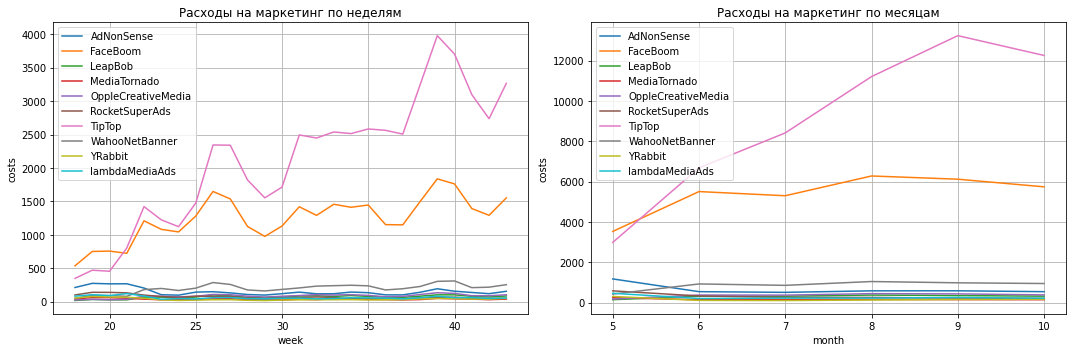

In [30]:
plt.figure(figsize = (15,5))
#график 1
ax1 = plt.subplot(1,2,1)
ad_costs = costs.pivot_table(index='week', columns = 'channel', values = 'costs', aggfunc='sum')
ad_costs.plot(grid=True, ax = ax1)
plt.legend()
plt.xlabel('week')
plt.ylabel('costs')
plt.title('Расходы на маркетинг по неделям')

#график 2
ax2 = plt.subplot(1,2,2)
ad_costs = costs.pivot_table(index='month', columns = 'channel', values = 'costs', aggfunc='sum')
ad_costs.plot(grid=True, ax = ax2)
plt.legend()
plt.xlabel('month')
plt.ylabel('costs')
plt.title('Расходы на маркетинг по месяцам')

plt.tight_layout()
plt.show()

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Очевидно, что есть два источника, которым компания отдает приоритет во вложении средств: это Face Boom и Tip Top. Расходы на оба канала постоянно растут, Tip Top интенсивно. Остальные источники на протяжении исследуемого периода примерно на одном уровне.

In [31]:
#для оценки показателей ROI, LTV и CAC исключим пользователей канала Organic, т к затраты на них = 0
ad_profiles = profiles.query('channel != "organic"')

In [32]:
# строим сводную таблицу для расчета срелнего CAC по каналам привлечения
cac = ad_profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
)
cac = cac.sort_values(by='acquisition_cost', ascending=False)
cac

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


[Text(0.5, 0, 'channel'), Text(0, 0.5, 'acquisition_cost')]

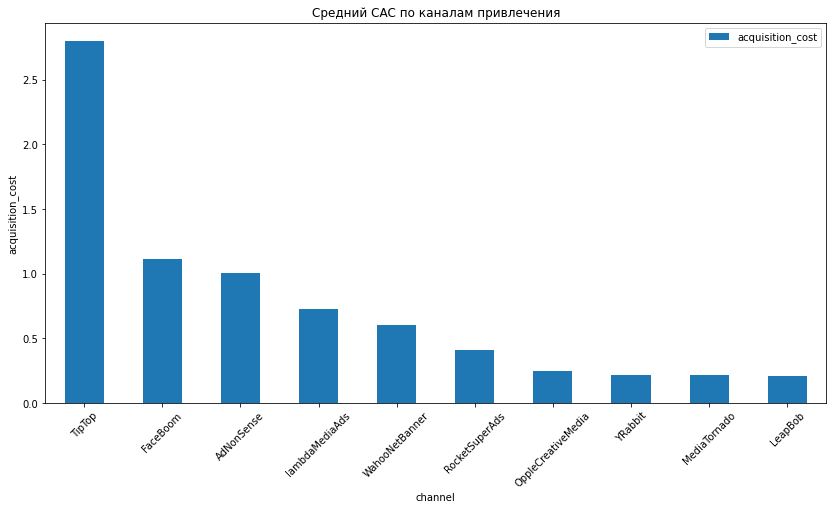

In [33]:
dx = cac.plot.bar(title='Средний CAC по каналам привлечения', rot=45, figsize=(14,7))

dx.set(xlabel='channel', ylabel='acquisition_cost')

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Стоимость привлечения «органических» пользователей равна нулю, т к  они перешли в приложение самостоятельно, а не благодаря рекламе. Поэтому их данные можно не учитывать. Привлечение одного пользователя из TipTop обошлось компании в среднем в 3 у.е., из FaceBoom в 1,11 - это два источника с наиболее "дорогими" пользователями. Также недешево обходится привлечение из AdNonSense — примерно в $1.

## Окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее, чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [34]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

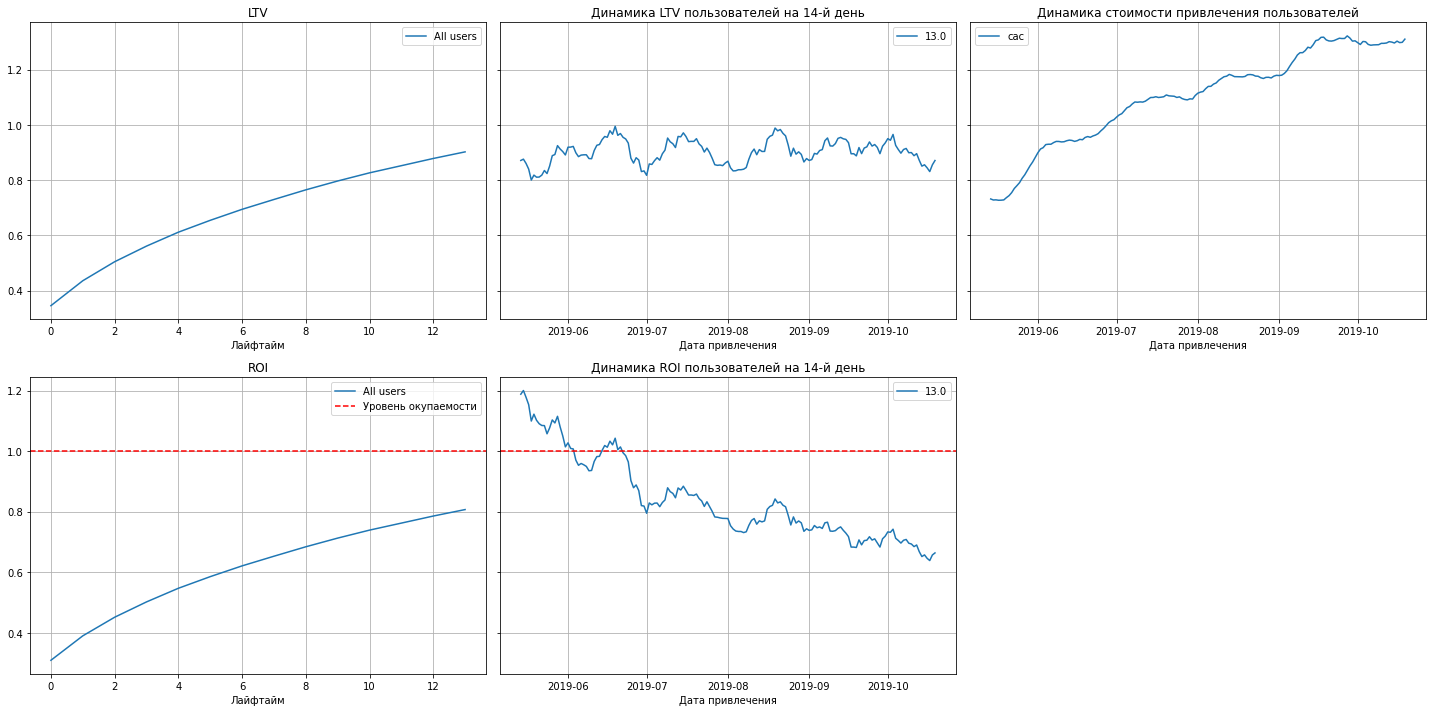

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Исходя из графиков можно сделать следующие выводы:
<br> - динамика LTV, ценности клиента, в целом стабильна, проблема не в качестве пользователей
<br> - CAC показывает интенсивный рост, динамика роста устойчивая, стоит обратить внимание на рост расходов
<br> - ROI: реклама не окупается. ROI в конце двухнедельного периода — чуть выше 80%. 
<br> - Динамика ROI устойчиво отрицательная
<br> В целом можно предположить, что вложения в маркетинг неэффективны. Расходы растут, отдача падает. Для выявления неэффектиных источников пользователей необходимо рассмотреть показатели в разрезах по регионам, каналам привлечения и устройствам.    

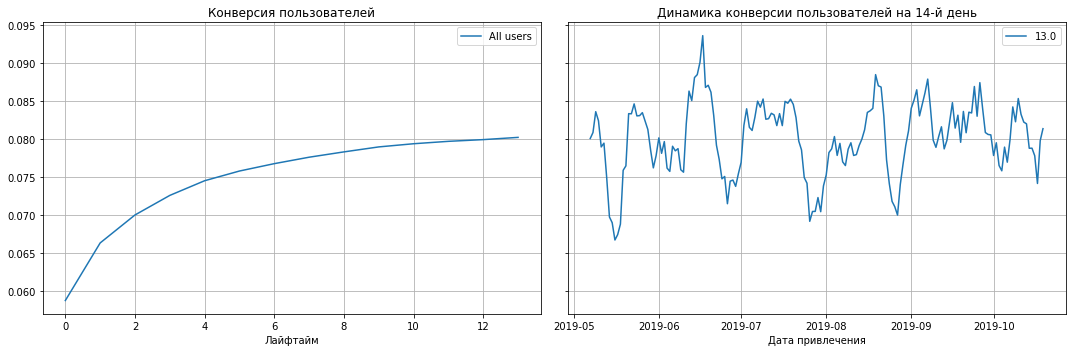

In [36]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ad_profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

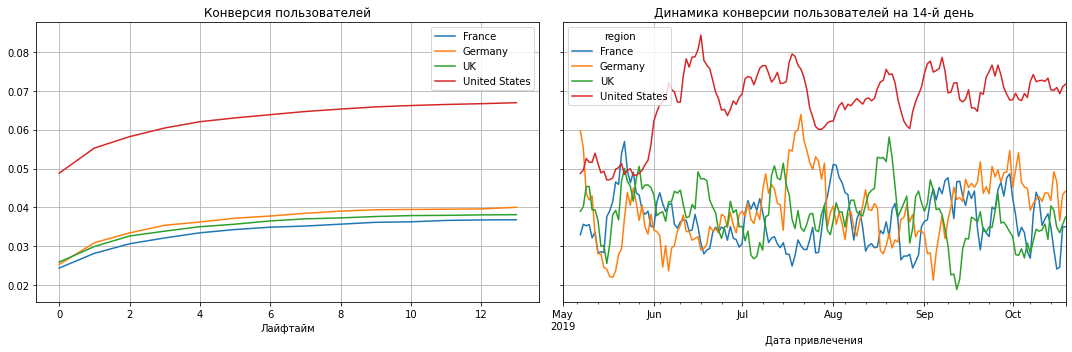

In [37]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

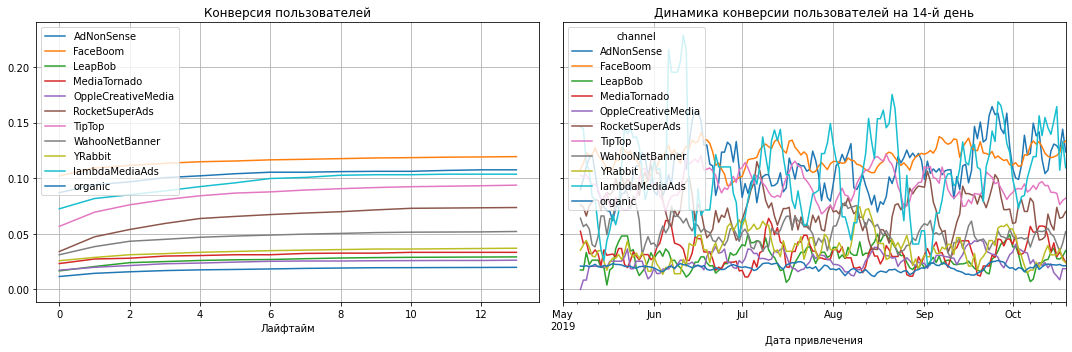

In [38]:
# смотрим конверсию с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

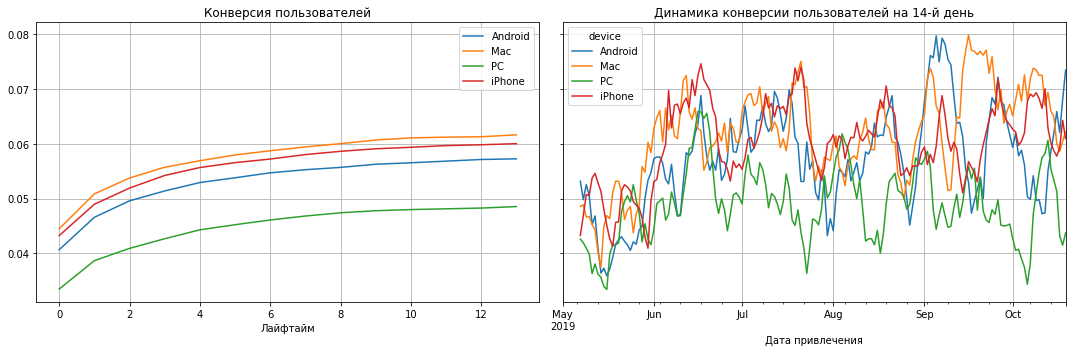

In [39]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 - пользователи из США конвертируются значительно лучше других стран
<br> - каналы с наибольшей конверсией: FaceBoom, AdNonSense, LambdaMediaAds, TipTop, RocketSuperAds. Три из них (наиболее <br> объемные по числу пользователей) актуальны только для США: FaceBoom, TipTop, RocketSuperAds.
<br> - конверсия по устройствам также говорит в пользу США: лидируют устройства Apple: Mac и IPhone. Чуть меньше пользователей конвертируются с устройств Android и меньше всего PC. 
<br>В целом пользователи Procrastinate Pro+ хорошо конвертируются, показатель в динамике стабилен. Вероятно, дело не в качестве пользователей.

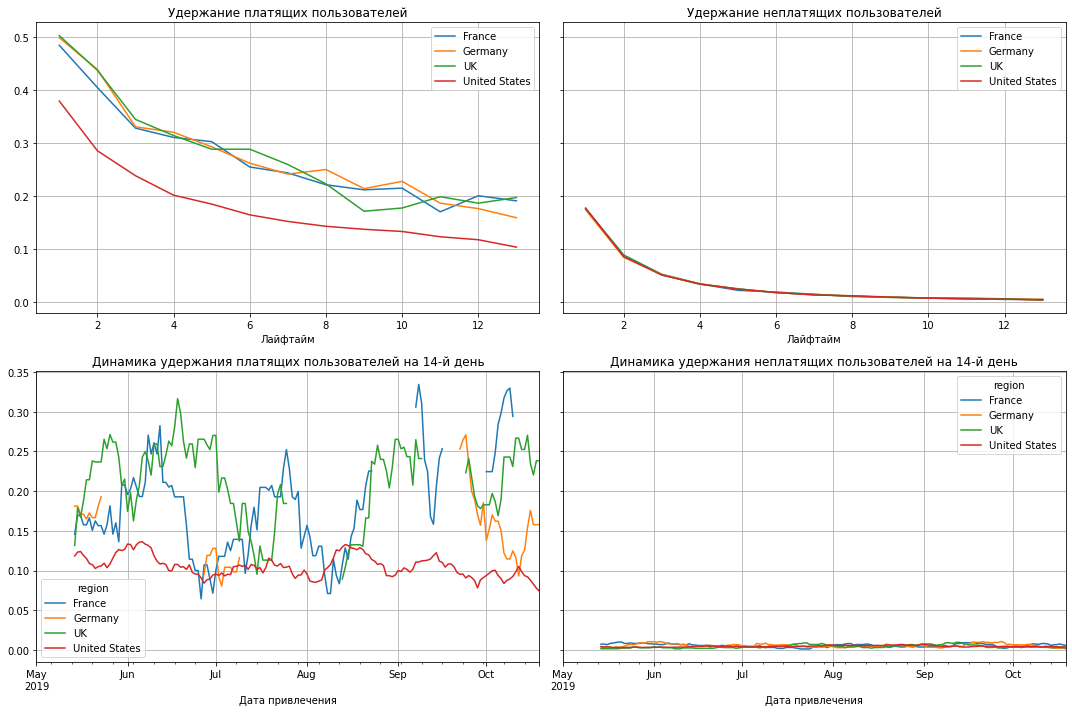

In [40]:
# смотрим удержание с разбивкой по регионам:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Удержание в США значительно ниже других стран. Рассмотрим в разрезе каналов:

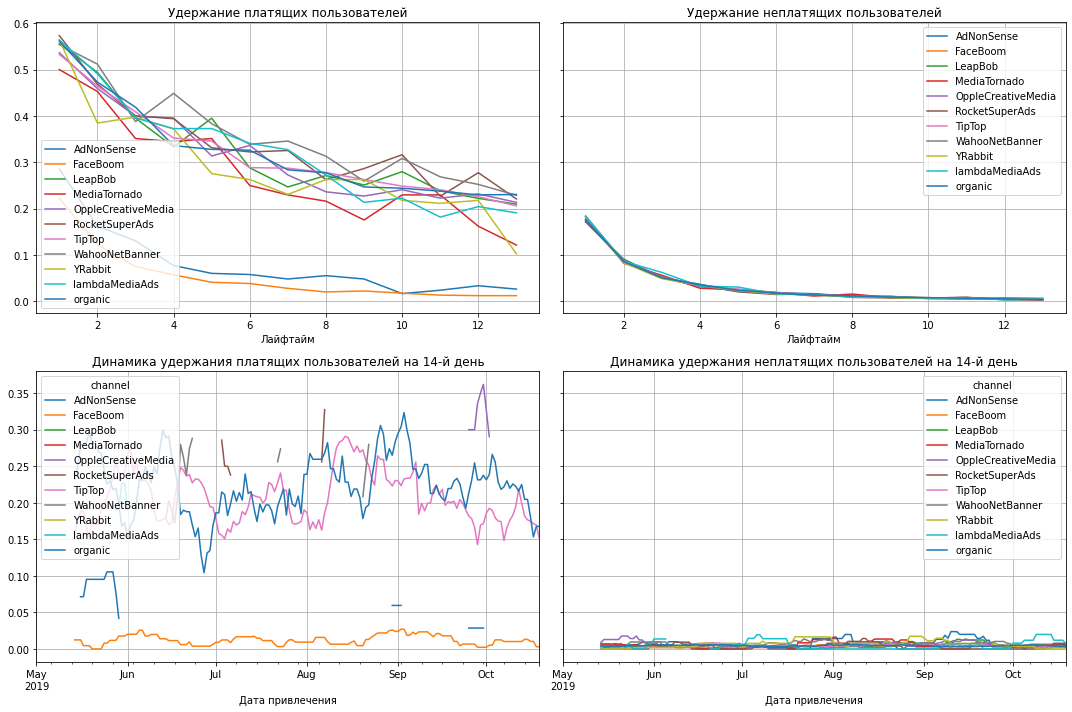

In [41]:
# смотрим удержание с разбивкой по каналам:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Платящие пользователи Procrastinate Pro+ неплохо удерживаются, за исключением клиентов, пришедших из FaceBoom и органических пользователей. Теперь ясна причина, по которой США плохо удерживаются: этот показатель низкий для канала, который лидирует в США по числу пользователей. Возможно причина в технической ошибке?

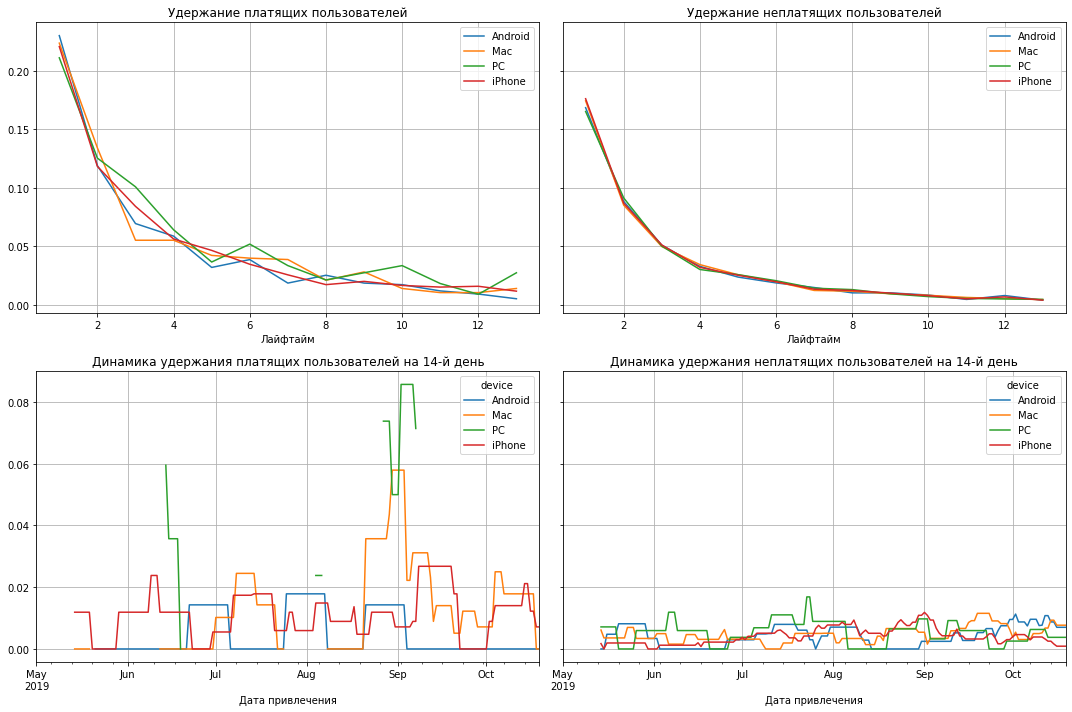

In [42]:
#число уникальных покупателей из США по каналам:
device_retention_USA = profiles.query('channel=="FaceBoom" and region=="United States"')
device_retention_USA.head()

# смотрим удержание с разбивкой по устройствам
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    device_retention_USA, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 По графикам нельзя сделать однозначный вывод, что дело в технической ошибке и в целом недостаточно данных для такого вывода. Есть признаки того, что для пользователей PC покупки в приложении по каким-либо причинам не удобны. В любом случае стоит обратить внимание на это канал привлечения и разработать мероприятия по удержанию пользователей.

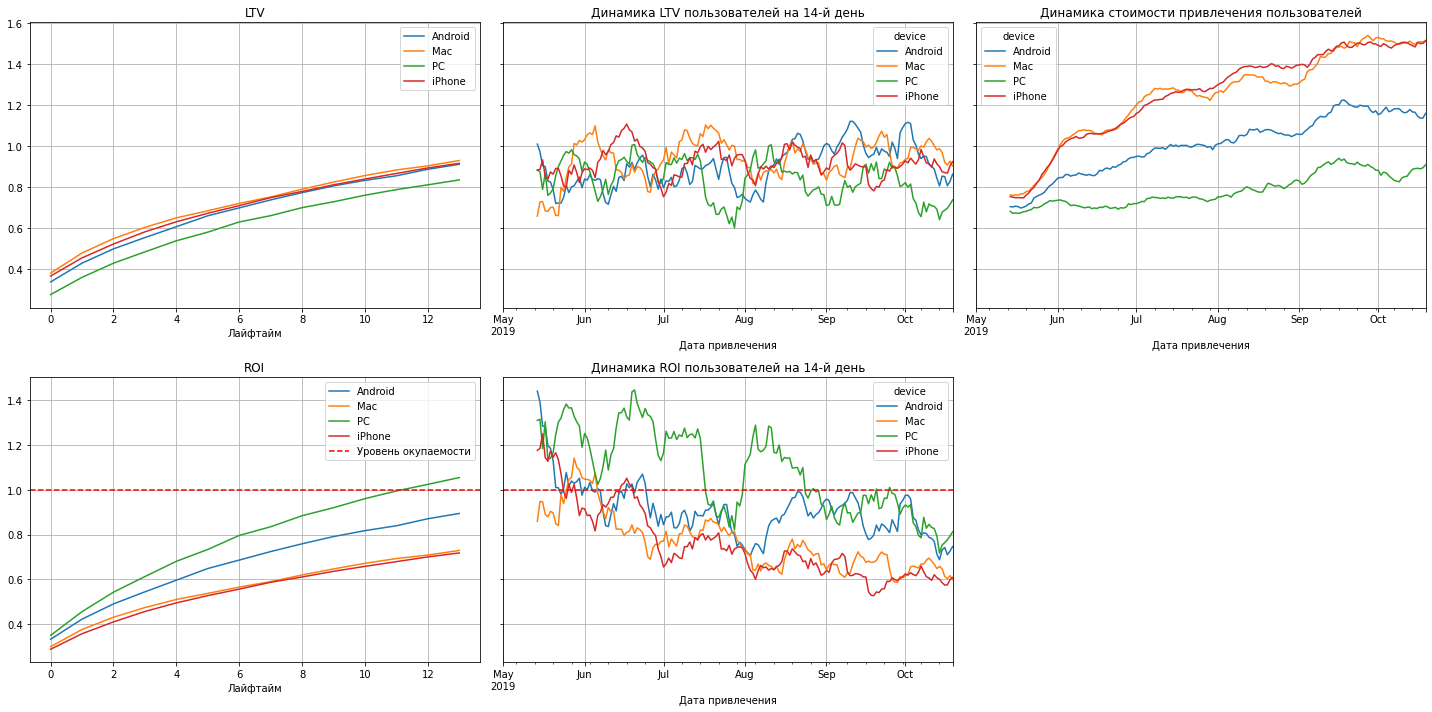

In [43]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Исходя из визуализации данных по утройствам можно сделать следующие выводы:
<br> - LTV по всем каналам в целом стабилен 
<br> - стоимость привлечения растет: наиболее интенсивно для каналов Mac и IPhone, Android показывает среднюю динамику, а PC <br> растет медленне остальных 
<br> - реклама не окупается по всем устройствам, за исключением PC: в конце периода график приблизился к отметке 105-110%. Но учитывая, что у пользователей PC наименьшая доля платящих, вряд ли это спасает ситуацию. 
<br> - окупаемость PC вероятно объясняется низким ростом затрат на этот канал. Но динамика показателя у PC также как и у остальных устройств отрицательная и все же уходит ниже границы окупаемости в конце исследуемого периода.
<br>Очевидно проблема в росте стоимости привлечения, особенно остро стоит у пользователей Mac и IPhone, которые очень популярны в США. В таком случае, стоит обратить внимание на показатели в разбивке по странам.

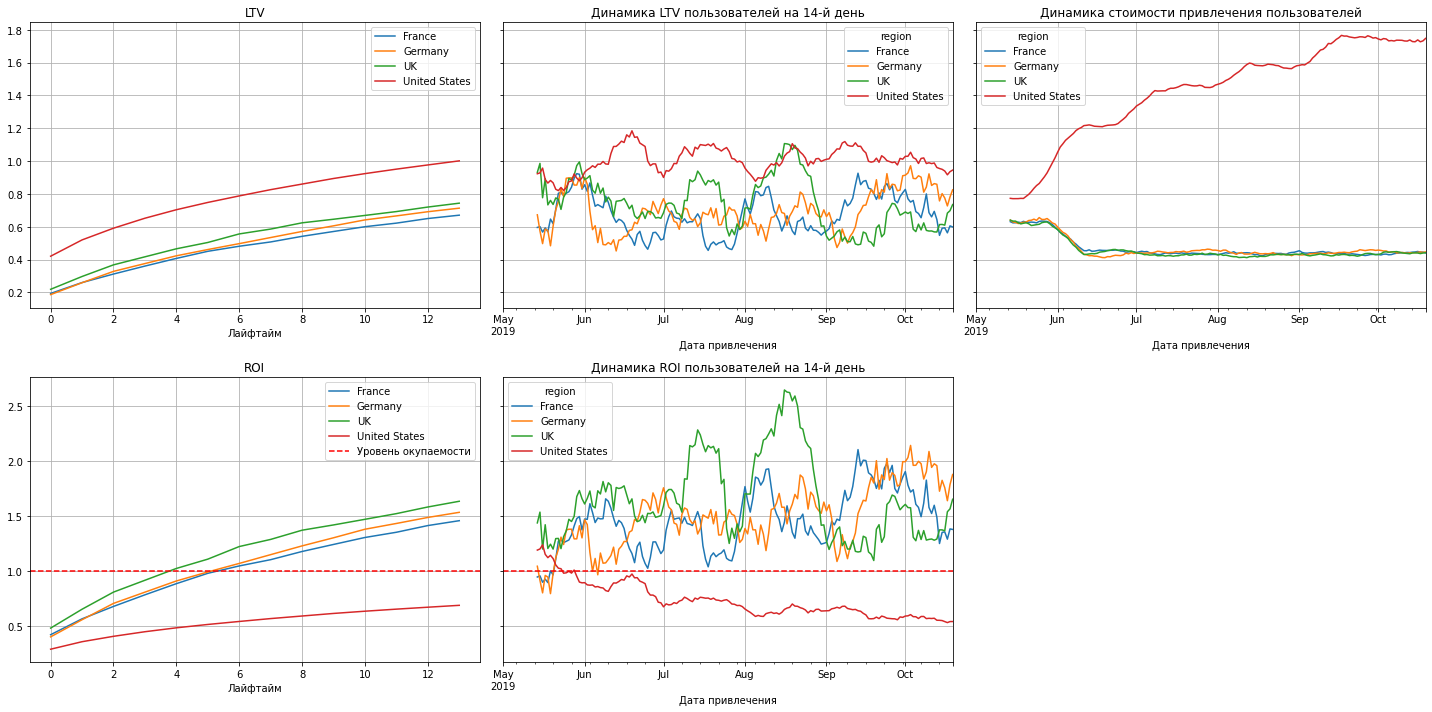

In [44]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Исходя из визуализации данных по странам можно сделать следующие выводы:
<br> - ценность пользователей из США значительно выше остальных регионов. Из остальных наибольшую ценность составляют пользователи Великобритании, далее следуют Германия и Франция.
<br> - динамика LTV стабильна
<br> - кажется, разгадка близка: стоимость привлечения пользователей из США иненсивно растет, в то время как по остальным странам стоимость напротив снизилась в мае-июне, и далее оставалась практически неизменной. 
<br> - неудивительно, что ROI в среднем по пользователям из США далек от окупаемости, в конце двухнедельного периода он около 70%. ROI по другим странам при этом выше точки окупаемости и состаляет на конец двух недель около 150%
<br> - в динамике ROI пользователей из США постоянно падает, по остальным странам есть общий тренд небольшого роста.
<br> - для пользователей из Великобритании на графиках ROI характерны два пика: в июле и в августе. Учитывая, что периоды совпадают с пиками на графике LTV, можно предположить, что это периоды маркетинговой активности имеено для этой страны, либо на повышенный спрос могли повлиять иные внутренние факторы региона.
<br>Стоит обратить внимание на стоимость привлечения пользователей из США, в чем могут быть причины такого резкого роста.  

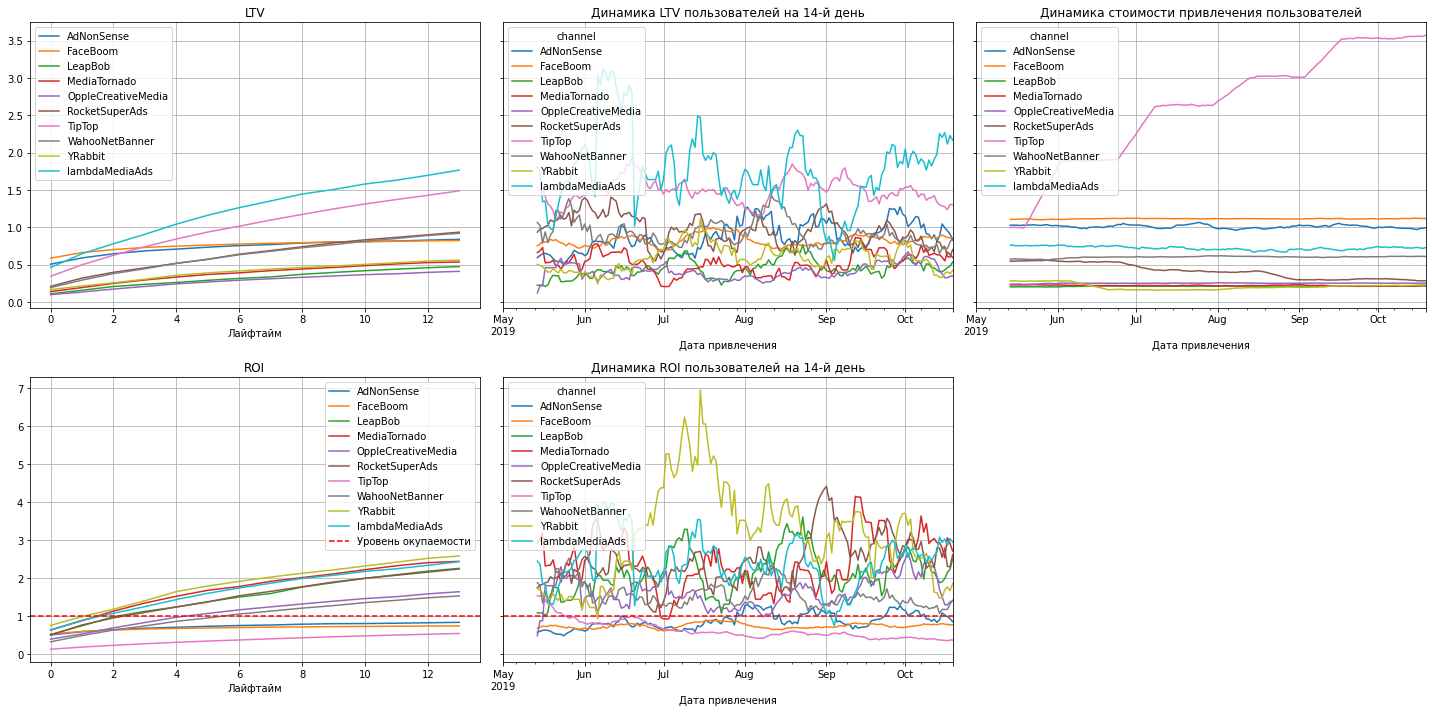

In [45]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Исходя из визуализации данных по каналам привлечения можно сделать следующие выводы:
<br> - наибольшая "пожизненная ценность пользователя" у клиентов из Lambda Media Ads и Tip Top. Чуть меньше у Rocket Super Ads, Wahoo Net Banner, Ad Non Sense и Face Boom.
<br> - динамика по каналам стабильна, за исключением Lambda Media Ads, которая отличается несколькими пиками и парой провалов. По числу пользователей канал наименьший, возможно поэтому скачки в графике более выраженные.
<br> - за счет пика ROI в июле и августе и снижения CAC в этот же период канал YRabbit показывает высокую среднюю окупаемость. Но LTV канала низкий.   
<br> - графики динамики стоимости привлечения по каналам дают нам еще один ключ к разгадке: канал Tip Top показывает стремительный рост стоимости. Ежемесячно показатель поднимается на очередной уровень выше.
<br> - остальные каналы привлечения стабильны, кроме Rocket Super Ads, где показатель снижается.
<br> - при всей ценности клинтов каналов Face Boom и Tip Top, ни один из них не окупается, а ROI Tip Top закономерно падает в динамике. Также не окупаются пользователи канала Ad Non Sense, у которого и ценность пользователя не слишком высока.
    
Стоит отметить, что динамика роста CAC клиентов из США и клиентов канала Tip Top крайне схожа. Вероятно доля пользователей, пришедших из TipTop, для США велика. Проверим гипотезу:   

In [46]:
#число уникальных покупателей из США по каналам:
channel_payers_USA = (
         ad_profiles.query('region=="United States"')   
        .groupby(['channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers_USA'})
        .reset_index()
    )
channel_payers_USA['channel_share_USA'] = channel_payers_USA['unique_payers_USA']/( channel_payers_USA['unique_payers_USA'].sum())*100
channel_payers_USA = channel_payers_USA.sort_values(by='channel_share_USA',ascending = False)
channel_payers_USA

,channel,unique_payers_USA,channel_share_USA
0,FaceBoom,29144,47.136457
3,TipTop,19561,31.637258
2,RocketSuperAds,4448,7.194035
1,MediaTornado,4364,7.058177
4,YRabbit,4312,6.974074


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Действительно, в США из канала Tip Top приходит 31.6% пользователей. Неудивительно, что стоимость по стране настолько выросла. Какие каналы популярны в других странах?

In [47]:
#число уникальных покупателей из Великобритании по каналам:
channel_payers_UK = (
         ad_profiles.query('region=="UK"')   
        .groupby(['channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers_UK'})
        .reset_index()
    )
channel_payers_UK['channel_share_UK'] = channel_payers_UK['unique_payers_UK']/( channel_payers_UK['unique_payers_UK'].sum())*100
channel_payers_UK = channel_payers_UK.sort_values(by='channel_share_UK',ascending = False)
channel_payers_UK

,channel,unique_payers_UK,channel_share_UK
2,OppleCreativeMedia,3052,27.362381
1,LeapBob,3046,27.308589
3,WahooNetBanner,3003,26.923077
0,AdNonSense,1295,11.610185
4,lambdaMediaAds,758,6.795768


In [48]:
#число уникальных покупателей из США по каналам:
channel_payers_Germany = (
         ad_profiles.query('region=="Germany"')   
        .groupby(['channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers_Germany'})
        .reset_index()
    )
channel_payers_Germany['channel_share_Germany'] = channel_payers_Germany['unique_payers_Germany']/( channel_payers_Germany['unique_payers_Germany'].sum())*100
channel_payers_Germany = channel_payers_Germany.sort_values(by='channel_share_Germany',ascending = False)
channel_payers_Germany

,channel,unique_payers_Germany,channel_share_Germany
3,WahooNetBanner,2579,27.067590
2,OppleCreativeMedia,2562,26.889169
1,LeapBob,2519,26.437867
0,AdNonSense,1219,12.793871
4,lambdaMediaAds,649,6.811503


In [49]:
#число уникальных покупателей из США по каналам:
channel_payers_France = (
         ad_profiles.query('region=="France"')   
        .groupby(['channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_payers_France'})
        .reset_index()
    )
channel_payers_France['channel_share_France'] = channel_payers_France['unique_payers_France']/( channel_payers_France['unique_payers_France'].sum())*100
channel_payers_France = channel_payers_France.sort_values(by='channel_share_France',ascending = False)
channel_payers_France

,channel,unique_payers_France,channel_share_France
2,OppleCreativeMedia,2991,27.048291
1,LeapBob,2988,27.021161
3,WahooNetBanner,2971,26.867426
0,AdNonSense,1366,12.353048
4,lambdaMediaAds,742,6.710074


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Европейких пользователей привлекаютв основном через каналы OppleCreativeMedia, WahooNetBanner и LeapBob. 
<br> - лидер по числу пользователей OppleCreativeMedia имеет самые низкие показатели LTV и доли платящих пользователей, хотя затраты и окупаются. 
<br> - LeapBob имеет также низкие маркетинговые показатели при окупаемости расходов в целом. 
<br> - На WahooNetBanner стоит обратить внимание, т к у кнала неплохой процент платящих пользователей, средняя ценность пользователя, невысокий CAC и достаточно высокий ROI

# Выводы

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Причины неэффективности привлечения пользователей следующие:
<br> - резкий рост стоимости привлечения клиентов в США через канал TipTop
<br> - низкое удержание пользователей США для канала FaceBook    
<br> - возможно недостаточное использование каналов, которые дают существенный поток ценных пользователей и показывают положительный ROI: Rocket Super Ads, Wahoo Net Banner
<br> -  канал Ad Non Sense хоть и находится на предпоследнем месте по численности привлеченных пользователей, но генерит убытки.
<br> -  канал OppleCreativeMedia, который лидирует по числу пользователей в Европе, характеризуется низкой конверсией и LTV    

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">
💬 Сопоставим данные конверсии, удержания, LTV, CAC и ROI по каналам, странам и устройствам:
<br> - наибольшее влияние на отдачу от маркетинговых инвестиций имеют показатели канала Tip Top. У него большая аудитория в США, которая лидирует среди регионов пользователей, при этом наибольший рост стоимости привлечения. Необходимо пересмотреть объем инвестиций на продвижение до уровня их окупаемости. Канал привлекает ценных пользователей и при оптимизации затрат внесет существенный вклад в решение проблемы окупаемости.      
<br> - наиболее конвертируемые пользователи у каналов FaceBoom, AdNonSense, LambdaMediaAds, TipTop,. При этом по числу платных пользователей  FaceBoom занимает первое место. Если стоимость привлечения из FaceBoom удастся оптимизировать, то канал извлечет из ценности клиентов прибыль, и это существенно улучшит ситуацию.
<br>  - Необходимо улучшить удержание пользователей канала FaceBoom. Это повысит показатели продаж и следовательно отдачу на инвестиции.    
<br> - пользователи из lambdaMediaAds по численности находятся на последнем месте во всех странах использования, но характеризуются высокой конверсией и ценностью. Стоит обращать внимание на динамику канала. 
<br> - достаточно объемные по числу пользователей и средние по конверсии и LTV:
<br>        * Wahoo Net Banner, популярный в Европе 
<br>        * Rocket Super Ads, третий по числу клиентов в США
<br>   Возможно, стоит пересмотреть объем инвестиций в эти каналы в сторону увеличения
<br> - также стоит пересмотреть инвестиции в OppleCreativeMedia и Ad Non Sense, но уже в сторону уменьшения.
<br> - конверсия по устройствам говорит в пользу устройств Apple: Mac и IPhone. Стоит проработать платежные сервисы для Android и PC.   